In [26]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from json import dumps
from time import time
import re
from collections import Counter
import string
from scipy.stats import ks_2samp, entropy
import torch
from torch.utils.data import TensorDataset, DataLoader
from joblib import Parallel, delayed

In [27]:
"""
Provides a set of functions for analyzing and processing file-related text data.
The primary focus is on extracting meaningful features from file metadata (e.g., filename, extension)
and comparing the character distributions within the filenames to English language letter frequencies.

Key Functions:
- `clean_string`: Cleans a string by removing unnecessary characters (like backslashes) to prepare it for analysis.
- `calculate_entropy`: Calculates the entropy (a measure of unpredictability) of a given string, useful for assessing the randomness of file names.
- `compute_euclidean_distance`: Computes the Euclidean distance between the letter distribution of a given text and the English letter frequency distribution.
- `compute_ks_statistic`: Computes the Kolmogorov-Smirnov statistic, which measures the distance between the cumulative distributions of character frequencies in a text and English letter frequencies.
- `compute_kl_divergence`: Computes the Kullback-Leibler divergence between the text's letter frequency distribution and the reference English distribution, which measures the "distance" between the two distributions.
- `parallel_apply`: A utility function that allows parallel processing of a specific function across a DataFrame column, improving performance for large datasets.

"""
CSV_DTYPES = {'Filename':str, 'Extension': str, "Is_Common_Extension":bool, "Contains_Double_Ext":bool, "Contains_ADS":bool, "Is_Malicious":bool}

english_freq = {
      'a': 8.2, 'b': 1.5, 'c': 2.8, 'd': 4.3, 'e': 13.0, 'f': 2.2, 'g': 2.0,
      'h': 6.1, 'i': 7.0, 'j': 0.15, 'k': 0.77, 'l': 4.0, 'm': 2.4, 'n': 6.7,
      'o': 7.5, 'p': 1.9, 'q': 0.095, 'r': 6.0, 's': 6.3, 't': 9.1, 'u': 2.8,
      'v': 0.98, 'w': 2.4, 'x': 0.15, 'y': 2.0, 'z': 0.074
}

# Normalize frequencies so they sum to 1
total_freq = sum(english_freq.values())
english_freq = {k: v / total_freq for k, v in english_freq.items()}

def clean_string(s):
    """Remove backslashes and unnecessary characters before entropy calculation."""
    return s.replace("\\", "").strip()  # Remove `\` to focus on meaningful content

def calculate_entropy(filepath):
  string_to_calculate = clean_string(filepath)
  entropy = float(0)
  if string_to_calculate is None:
    return None
  else:
    string_to_calculate = str(string_to_calculate)
    counts = Counter(string_to_calculate)
    length = len(string_to_calculate)
    probabilities = [count / length for count in counts.values()]
    entropy = -sum(p * np.log2(p) for p in probabilities)

    return entropy

def compute_euclidean_distance(text):
    """
    Compute the Euclidean distance between the letter distribution in a given text
    and the reference English letter frequency.
    """
    if not isinstance(text, str) or not text:
        return None  # Return None if input is invalid

    # Extract only English letters and convert to lowercase
    filtered_chars = [c.lower() for c in text if c in string.ascii_letters]

    # Count letter frequencies
    file_freq = Counter(filtered_chars)
    total_chars = sum(file_freq.values())

    # Normalize to probability distribution
    file_prob = {char: count / total_chars for char, count in file_freq.items()} if total_chars > 0 else {char: 0 for char in english_freq}

    # Compute Euclidean distance
    distance = np.sqrt(sum((file_prob.get(char, 0) - english_freq[char]) ** 2 for char in english_freq))

    return distance

def compute_ks_statistic(text):
    """Computes the Kolmogorov-Smirnov statistic between character frequencies in text and reference_freq."""
    if not text:
        return 0
    counter = Counter(c for c in text if c.isalpha())
    total = sum(counter.values())
    text_freq = {char: count / total for char, count in counter.items()}
    text_values = list(text_freq.values())
    reference_values = list(english_freq.values())

    if not text_values or not reference_values:
        return 0

    return ks_2samp(text_values, reference_values).statistic

def compute_kl_divergence(text):
    """Computes the Kullback-Leibler divergence between character frequencies in text and reference_freq."""
    if not text:
        return 0
    counter = Counter(c for c in text if c.isalpha())
    total = sum(counter.values())
    text_freq = {char: count / total for char, count in counter.items()} if total > 0 else {}

    all_chars = set(english_freq.keys()).union(text_freq.keys())
    text_dist = [text_freq.get(char, 1e-10) for char in all_chars]      # Small smoothing value
    reference_dist = [english_freq.get(char, 1e-10) for char in all_chars]

    return entropy(text_dist, reference_dist)  # scipy's entropy computes KL divergence by default

def parallel_apply(df, column, func, n_jobs=-1):
    """Parallel apply of func to a DataFrame column."""
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(func)(val) for val in df[column]
    )
    return results

In [ ]:
"""
Data Preprocessing Stage

This stage handles various preprocessing steps for preparing the data to be used in machine learning models.
The operations performed include the following:

The function `prepare_data` returns the features (X), target (y), and the preprocessed DataFrame (df) for use in machine learning tasks.

This preprocessing pipeline ensures that the data is properly cleaned, transformed, and normalized, making it ready for modeling.
"""

label_encoders = {}
scaler = MinMaxScaler()  # Initialize MinMaxScaler
def prepare_data(csv_path):
    start_time = time()
    df = pd.read_csv(csv_path, dtype=CSV_DTYPES)
    print(f'{time()-start_time} Finished reading {csv_path}')
    df['Extension'] = df['Extension'].fillna('')  # Replace NaN with empty string

    special_chars = "_-.@#!$%^&*"
    df['Full_Filepath_Length'] = df['Full_Filepath'].apply(len)
    df['Filename'] = df['Filename'].apply(str)
    df['Filepath_Length'] = df['Filepath'].apply(len)
    df['Extension_Length'] = df['Extension'].apply(len)

    #add a new feature ; presences of special characters
    df['Special_Character_Exist'] = df['Full_Filepath'].apply(lambda x: 1 if re.search(r'[^a-zA-Z0-9\\/]', str(x)) else 0)
    df['Special_Char_Count'] = df['Filename'].apply(lambda x: sum(x.count(c) for c in special_chars))
    print(f'{time()-start_time} Finished length and special character {csv_path}')


    # Parallel computation of expensive functions
    df['Full_Filepath_Entropy'] = parallel_apply(df, 'Full_Filepath', calculate_entropy)
    df['Filepath_Entropy'] = parallel_apply(df, 'Filepath', calculate_entropy)
    df['Filename_Entropy'] = parallel_apply(df, 'Filename', calculate_entropy)
    print(f'{time()-start_time} Finished entropy {csv_path}')

    df['Full_Filepath_EucliD'] = parallel_apply(df, 'Full_Filepath', compute_euclidean_distance)
    df['Filepath_EucliD'] = parallel_apply(df, 'Filepath', compute_euclidean_distance)
    df['Filename_EucliD'] = parallel_apply(df, 'Filename', compute_euclidean_distance)
    print(f'{time()-start_time} Finished euclidean {csv_path}')

    df['Full_Filepath_Kolmo'] = parallel_apply(df, 'Full_Filepath', compute_ks_statistic)
    df['Filepath_Kolmo'] = parallel_apply(df, 'Filepath', compute_ks_statistic)
    df['Filename_Kolmo'] = parallel_apply(df, 'Filename', compute_ks_statistic)
    print(f'{time()-start_time} Finished kolmo {csv_path}')

    df['Full_Filepath_KL'] = parallel_apply(df, 'Full_Filepath', compute_kl_divergence)
    df['Filepath_KL'] = parallel_apply(df, 'Filepath', compute_kl_divergence)
    df['Filename_KL'] = parallel_apply(df, 'Filename', compute_kl_divergence)
    print(f'{time()-start_time} Finished Kullback-Leibler {csv_path}')


    for column in ("Full_Filepath", "Filepath", "Filename", "Extension", "Alt_Data_Stream"):
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))  # Ensure string dtype for compatibility
        label_encoders[column] = le
    print(f'{time()-start_time} Finished label encoder {csv_path}')

    # Normalize numerical features
    normalized_values = scaler.fit_transform(df.select_dtypes(include=['number','bool']))  # Scale selected features
    df[df.select_dtypes(include=['number','bool']).columns] = normalized_values  # Replace with normalized values
    print(f'{time()-start_time} Finished normalizing {csv_path}')

    # Define features (X) and target (y)
    X = df.drop(columns=['Is_Malicious']) # use everything to predict Is_Malicious
    y = df['Is_Malicious']
    print(f'{time()-start_time} Finished processing {csv_path}')
    return X,y,df

import os
file_path = os.path.join('Final Dataset', 'final_10000.csv')
X,y,df = prepare_data(file_path)
df

0.05697488784790039 Finished reading final_10000.csv
0.11705589294433594 Finished length and special character final_10000.csv
2.3602135181427 Finished entropy final_10000.csv
3.4316580295562744 Finished euclidean final_10000.csv
20.339977741241455 Finished kolmo final_10000.csv
37.03930640220642 Finished Kullback-Leibler final_10000.csv
37.10265851020813 Finished label encoder final_10000.csv
37.13219928741455 Finished normalizing final_10000.csv
37.13440155982971 Finished processing final_10000.csv


,Full_Filepath,Filepath,Filename,Extension,Alt_Data_Stream,Directory_Depth,Filename_Length,Is_Common_Extension,Contains_Double_Ext,Contains_ADS,...,Filename_Entropy,Full_Filepath_EucliD,Filepath_EucliD,Filename_EucliD,Full_Filepath_Kolmo,Filepath_Kolmo,Filename_Kolmo,Full_Filepath_KL,Filepath_KL,Filename_KL
0,0.394518,0.485183,0.342712,0.431373,0.764706,0.666667,0.237705,0.0,0.0,0.0,...,0.858035,0.120466,0.114014,0.122281,0.290909,0.269231,0.653846,0.051366,0.050862,0.070127
1,0.358307,0.449021,0.265398,0.196078,0.764706,0.333333,0.032787,0.0,0.0,0.0,...,0.391236,0.088749,0.048030,0.460769,0.181818,0.423077,1.000000,0.033476,0.022247,0.218570
2,0.583075,0.627574,0.618513,0.098039,0.764706,0.166667,0.475410,0.0,0.0,0.0,...,0.893739,0.137817,0.121694,0.195940,0.348485,0.615385,0.653846,0.066606,0.069213,0.120248
3,0.190857,0.269965,0.919494,0.200980,0.764706,0.416667,0.139344,1.0,0.0,0.0,...,0.690519,0.134717,0.091122,0.183303,0.262032,0.384615,0.730769,0.066536,0.045010,0.100583
4,0.733420,0.691863,0.240099,0.200980,0.764706,0.083333,0.057377,1.0,0.0,0.0,...,0.508910,0.304672,0.337950,0.339149,0.545455,0.884615,0.961538,0.175129,0.183663,0.248274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.402121,0.488699,0.824329,0.735294,0.764706,0.500000,0.319672,0.0,0.0,0.0,...,0.864423,0.134980,0.145906,0.168497,0.146465,0.274038,0.730769,0.061941,0.065710,0.086233
9996,0.152546,0.211452,0.052488,0.000000,0.764706,0.333333,0.180328,0.0,0.0,0.0,...,0.701739,0.054883,0.047936,0.128007,0.284689,0.366397,0.653846,0.039934,0.042464,0.052334
9997,0.122337,0.173029,0.362454,0.375000,0.764706,0.333333,0.049180,1.0,0.0,0.0,...,0.513316,0.148899,0.086938,0.332094,0.318182,0.576923,1.000000,0.060807,0.036914,0.199640
9998,0.046014,0.069563,0.597470,0.465686,0.764706,0.333333,0.081967,0.0,0.0,0.0,...,0.556170,0.091130,0.101521,0.175129,0.136364,0.500000,0.961538,0.023268,0.037402,0.084978


Total number of features without Is_Malicious: 27
Number of 1s (Malicious): 969
Number of 0s (Non-Malicious): 9031


<ipython-input-29-6ad499408a00>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=malicious_counts.index, y=malicious_counts.values, palette='Set2')


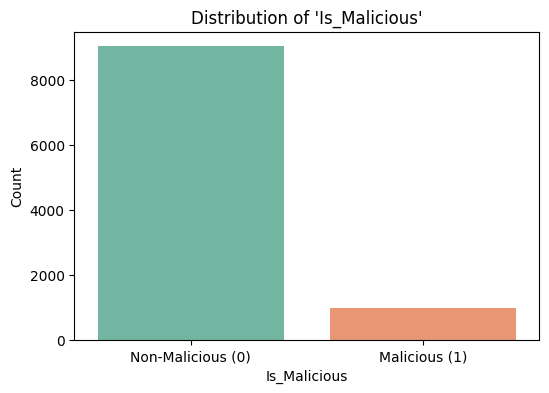

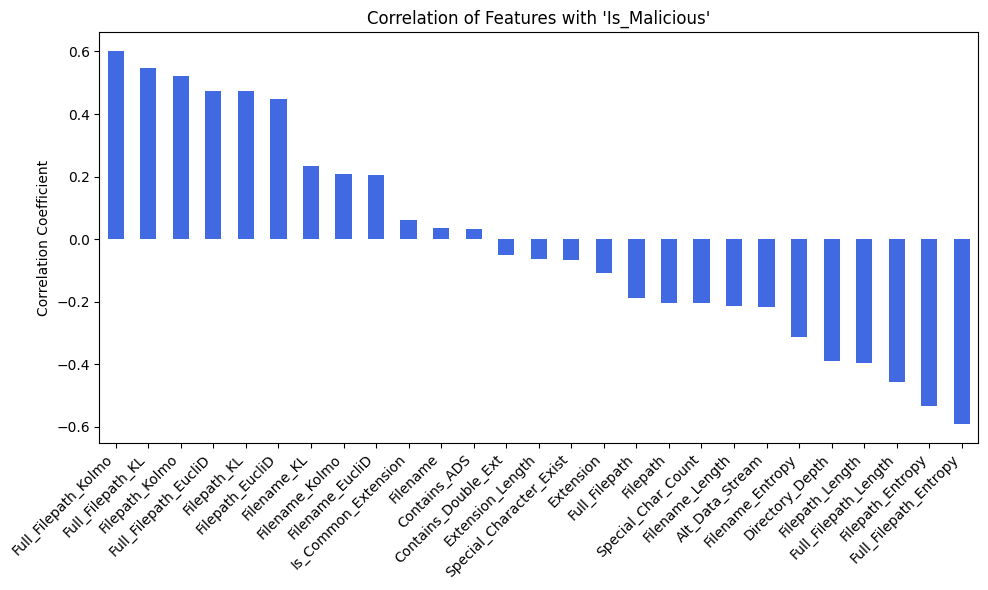

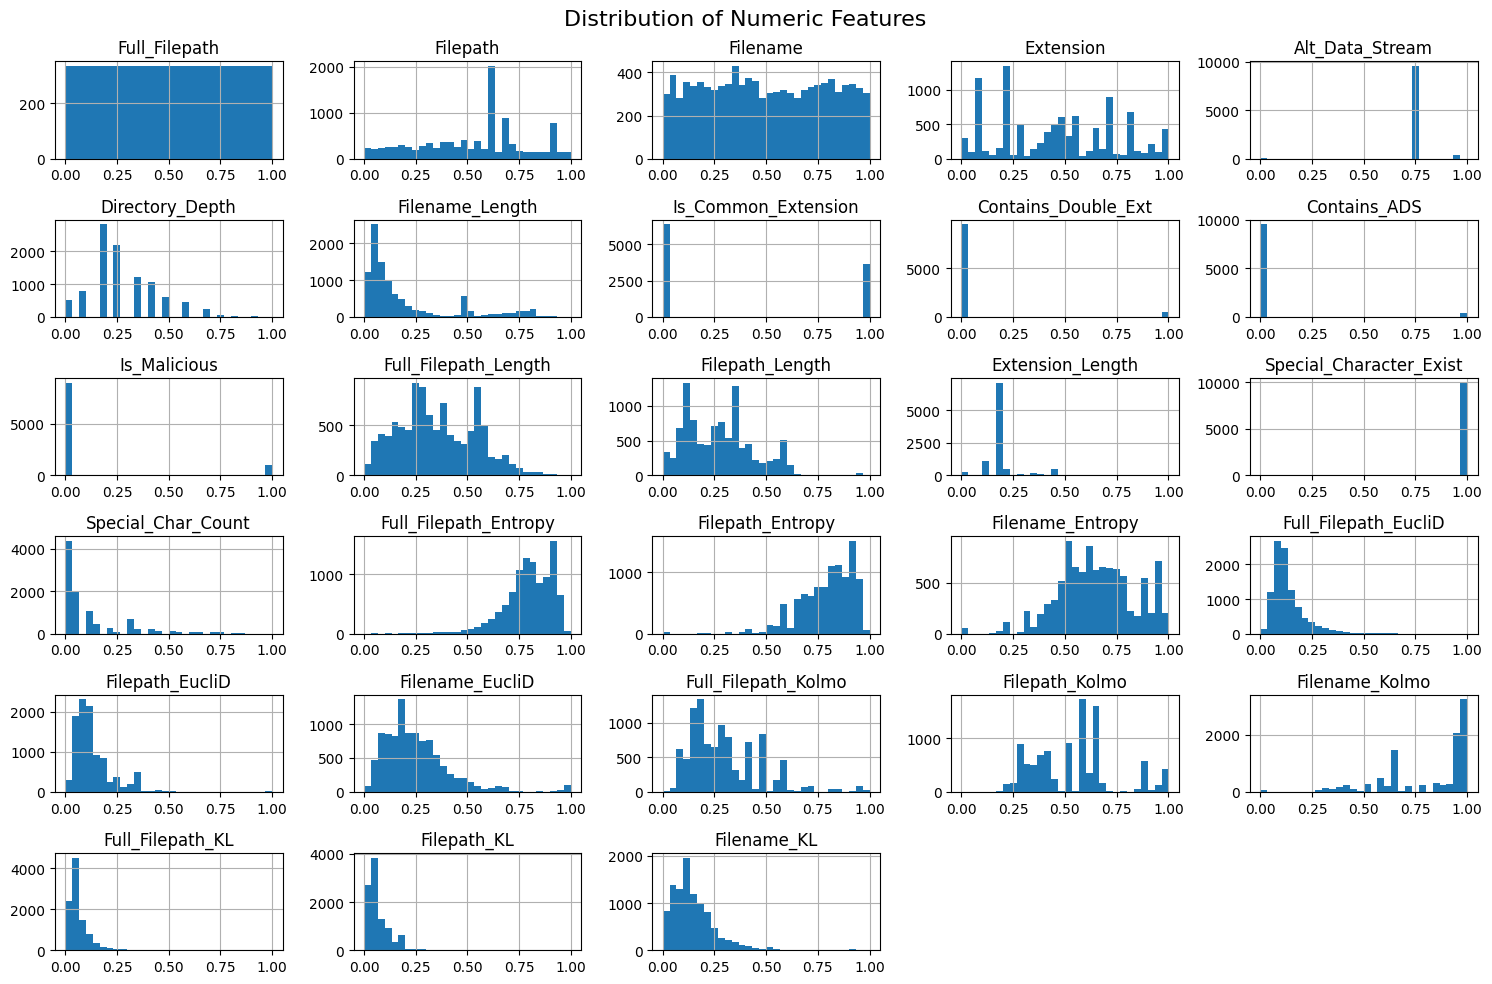

In [29]:
"""
Data Visualization

This section of the code visualizes key information about the features after preprocessing,
focusing on the correlation of each feature with the target variable ('Is_Malicious')
and the distribution of the scaled features.

"""

# for graph for features after all the processing
print(f"Total number of features without Is_Malicious: {df.drop(columns=['Is_Malicious']).shape[1]}")


# Count the number of 1s and 0s in 'Is_Malicious'
malicious_counts = df['Is_Malicious'].value_counts()

# Print the counts
print(f"Number of 1s (Malicious): {malicious_counts[1]}")
print(f"Number of 0s (Non-Malicious): {malicious_counts[0]}")

# Plot the bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x=malicious_counts.index, y=malicious_counts.values, palette='Set2')
plt.title("Distribution of 'Is_Malicious'")
plt.xlabel("Is_Malicious")
plt.ylabel("Count")
plt.xticks([0, 1], ['Non-Malicious (0)', 'Malicious (1)'])  # Label the x-axis
plt.show()

# Plot the correlation of each feature with the target 'Is_Malicious'
# Calculate the correlation between each feature and the target variable 'Is_Malicious'
correlation_with_target = df.corr()['Is_Malicious'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
correlation_with_target.drop('Is_Malicious').plot(kind='bar', color='royalblue')  # Drop 'Is_Malicious' for plotting
plt.title("Correlation of Features with 'Is_Malicious'")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot histograms for all features
# Plot histograms for all numeric columns in the DataFrame
df.select_dtypes(include=['int64', 'float64']).hist(figsize=(15, 10), bins=30)
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()


In [30]:
"""
Splitting Data into Training and Test Sets (80/20 Split)

In this stage, we split the preprocessed dataset into training and testing subsets.

Stratified Split:
- The `stratify=y` argument ensures that the split maintains the same proportion of classes (e.g., 'Is_Malicious' values) in both the training and test sets.
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
"""
Feature Selection and Optimization

In this stage, we identify and select the most important features based on their correlation with the target variable.
This helps reduce the complexity of the model by focusing on the features that have the most significant relationship with the target.

We aim to comparison of Models that are trained with all features and optimized features only:
- We aim to train two models for both KNN and Random Forest algorithms.
- Vanilla Model 1: Trained using all available features (no feature selection).
- Optimized Model 2: Trained using only the important features (those with high correlation to the target).
- By selecting the most relevant features, we can compare the performance scores of both models and observe the impact of feature selection on model accuracy and efficiency.

"""


def high_corr_features(df, threshold):
    """
    Select features that have a correlation > 0.5 or < -0.5 with the target variable.

    Parameters:
    df (DataFrame): The input dataframe.
    target (str): The name of the target column.
    threshold (float): The correlation threshold.

    Returns:
    List: A list of important feature names.
    """

    # Convert categorical data to numerical if necessary
    df_numeric = df.select_dtypes(include=['number','bool'])
    corr_matrix = df_numeric.corr()  # Compute correlation matrix
    target_corr = corr_matrix["Is_Malicious"].drop("Is_Malicious")  # Get correlation with target, excluding itself

    # Select features with strong correlation
    important_features = target_corr[abs(target_corr) > threshold].index.tolist()

    return important_features

important_features = high_corr_features(df,0.2)
print(important_features)

X_train_optimized = X_train[important_features]
X_test_optimized = X_test[important_features]

['Filepath', 'Alt_Data_Stream', 'Directory_Depth', 'Filename_Length', 'Full_Filepath_Length', 'Filepath_Length', 'Special_Char_Count', 'Full_Filepath_Entropy', 'Filepath_Entropy', 'Filename_Entropy', 'Full_Filepath_EucliD', 'Filepath_EucliD', 'Filename_EucliD', 'Full_Filepath_Kolmo', 'Filepath_Kolmo', 'Filename_Kolmo', 'Full_Filepath_KL', 'Filepath_KL', 'Filename_KL']


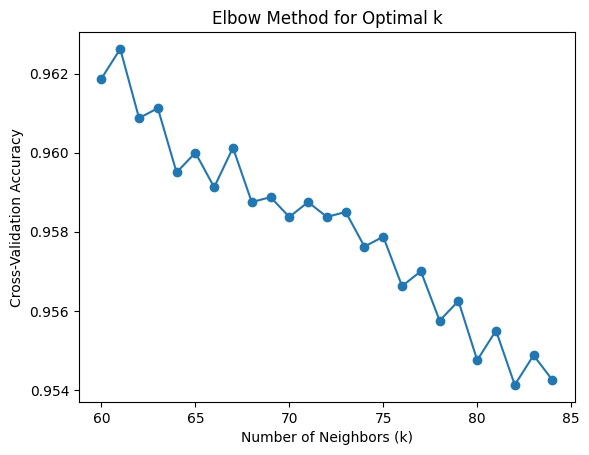

In [33]:
"""
Model Optimization and Hyperparameter Tuning

In this stage, we aim to optimize the performance of two machine learning models: K-Nearest Neighbors (KNN) and Random Forest.

1. KNN Optimization:
   - We perform hyperparameter tuning for the KNN model by testing different values for the number of neighbors (`k`) using cross-validation.
   - The Elbow Method is used to visualize the accuracy scores for various `k` values, helping to identify the best number of neighbors.

2. Random Forest Optimization:
   - We optimize the Random Forest model by performing **Randomized Search** over a defined parameter grid.
   - Hyperparameters such as `max_depth`, `min_samples_leaf`, `min_samples_split`, `n_estimators`, and `oob_score` are tuned using cross-validation.
   - Randomized Search is applied to efficiently search over the hyperparameter space by testing random combinations of parameters (`n_iter=20`), which balances speed and accuracy.

"""


k_values = range(60, 85)
scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train, cv=5).mean() for k in k_values]


plt.plot(k_values, scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Elbow Method for Optimal k')
plt.show()

# Initialize Random Forest Classifier
rf = RandomForestClassifier()
rf_optimized = RandomForestClassifier()

# Define parameter grid
param_dist = {
    'bootstrap': [True],
    'max_depth': np.arange(2, 9),  # Use numpy range for efficiency
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300],
    'oob_score': [True]
}

# Randomized Search (searches only 20 random combinations instead of all)
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Number of random trials (Adjust to balance speed & accuracy)
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_random_optimized = RandomizedSearchCV(
    estimator=rf_optimized,
    param_distributions=param_dist,
    n_iter=20,  # Number of random trials (Adjust to balance speed & accuracy)
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [38]:
"""
Model Training

In this stage, we train the models using the optimized hyperparameters:

1. KNN Model:
- The KNN model is trained with the best value of `n_neighbors` found through cross-validation.
- Both the full feature set and the optimized feature set are used to train two separate models for comparison.

2. Random Forest Model:
- The Random Forest model is trained using the best hyperparameters identified by Randomized Search with cross-validation.
- Two Random Forest models are trained: one with all features and one with optimized features.

The models are then trained on the training data, and their best configurations are printed for review.
"""


# Train KNN models
n_neighbors = 68
print(f"Training n_neighbors = {n_neighbors}...")
# TODO: fit the data to train the model
model = KNeighborsClassifier(n_neighbors=n_neighbors)

start_time = time()
model.fit(X_train, y_train)
print(f'{time()-start_time:.4f} sec - Finished training KNN with All features')
model_optimized = KNeighborsClassifier(n_neighbors=n_neighbors)
start_time = time()
model_optimized.fit(X_train_optimized, y_train)
print(f'{time()-start_time:.4f} sec - Finished training KNN with optimized features\n')

# Train RF
print("Training Random Forest...")


# Train model
start_time = time()
rf_random.fit(X_train, y_train)
print(f'{time()-start_time:.4f} sec - Finished training Random Forest with All features')
start_time = time()
rf_random_optimized.fit(X_train_optimized, y_train)
print(f'{time()-start_time:.4f} sec - Finished training Random Forest with optimized features\n')

# Print best parameters
#print("RF Best Parameters:", rf_random.best_params_)
#print("RF Optimized Best Parameters:", rf_random_optimized.best_params_)

# Get the best model
best_rf = rf_random.best_estimator_
best_rf_optimized = rf_random_optimized.best_estimator_


Training n_neighbors = 68...
0.0121 sec - Finished training KNN with All features
0.0067 sec - Finished training KNN with optimized features

Training Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
79.8371 sec - Finished training Random Forest with All features
Fitting 3 folds for each of 20 candidates, totalling 60 fits
67.7014 sec - Finished training Random Forest with optimized features



In [39]:
"""
Model Evaluation

In this stage, we evaluate the performance of the trained models (KNN and Random Forest) on the unseen test set.
Metrics such as accuracy, recall, F1 score, and execution time are calculated and displayed for both the full and optimized feature sets.
"""


# Evaluate performance based on unseen test set
def evaluate_model(y_true, X_test, model, dataset_name):
    start_time = time()
    y_pred = model.predict(X_test) # TODO: make predictions
    execution_time = time() - start_time
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average="binary")  # Change to "binary" if binary classification
    f1 = f1_score(y_true, y_pred, average="binary")

    print(f"{dataset_name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Execution time: {execution_time} seconds")
    print("-" * 30)



evaluate_model(y_test, X_test, model, f"KNN k={n_neighbors} All features")
evaluate_model(y_test, X_test_optimized, model_optimized, f"KNN k={n_neighbors} Optimized features")
evaluate_model(y_test, X_test, best_rf, "RF All features")
evaluate_model(y_test, X_test_optimized, best_rf_optimized, "RF Optimized features")

KNN k=68 All features Performance:
Accuracy: 0.9590
Recall: 0.6237
F1 Score: 0.7469
Execution time: 0.2768220901489258 seconds
------------------------------
KNN k=68 Optimized features Performance:
Accuracy: 0.9700
Recall: 0.7577
F1 Score: 0.8305
Execution time: 0.2952420711517334 seconds
------------------------------
RF All features Performance:
Accuracy: 0.9830
Recall: 0.8814
F1 Score: 0.9096
Execution time: 0.05781435966491699 seconds
------------------------------
RF Optimized features Performance:
Accuracy: 0.9850
Recall: 0.8969
F1 Score: 0.9206
Execution time: 0.05843377113342285 seconds
------------------------------
